<a href="https://colab.research.google.com/github/Sylar257/My-data-science-tool-kit/blob/master/Advanced_usage_for_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
1. Difference between PyTorch classes like `nn.Module`, `nn.Functional`
2. How to customize training options such as `lr` for different layers, *weight initialization*
3. **Tensorboard** with PyTorch
4. How to visualiza the computation graph and print it's intermediate values for **debugging**

## `nn.Module` vs `nn.Functional`

PyTorch layers are normally implemented with either `torch.nn.Module` objects or `torch.nn.Functional` functions.<br>
___
With `torch.nn.Module` we define layers in `__init__` and then invoke them in `forward` method. This is a *Object Oriented* way to do things.<br>
On the other hand, `nn.functional` provides some **layers/activations** in form of *functions* that can be directly called on the input rather than defining as an object. E.g., in order to rescale an image tensor, we can call `torch.nn.functional.interpolate` on an image tensor.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
# simulate an input of batch_size = 1, n_channels = 3, 64x64 image
inp = torch.randn(1,3,64,64) 


In [0]:
# torch.nn layers
avg_pool = nn.AvgPool2d(kernel_size=4)
nn_out = avg_pool(inp)

In [0]:
# torch.nn.Functional functions
f_out  = F.avg_pool2d(inp,kernel_size=4)

In [9]:
# check is the two are the same
print(torch.equal(nn_out, f_out))

True


### Stateful-ness in PyTorch
As the result of the two method are actually the same, the difference lies in their *statefulness*.<br>
In most cases, layers can be viewed as a function in PyTorch where we feed in an input and it spits out an output.In the mean time, layers holds **weights** and **biases** that need to be stored and updated while we are training. Therefore, programmatically, layers are more than just functions but hold these *states* that will be altered during our training.<br>
Hence, for layers that needs to hold certain **weights & biases** or any **states** we create a class for them with `torch.nn.Module`. **Batch Norm layers** and **dropout layers** behahves differently during training and inferernce which is also benificial to have them under `torch.nn.Module`.<br>
On the other hand, `torch.nn.functional` have the layers that bear no weights and no state.

### nn.Parameter
PyTorch has a `nn.Parameter` class, which will be automatically created with and `nn.Module`.

In [0]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10,5)
    
    def forward(self, x):
        return self.linear(x)

In [11]:
myNet = net()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[ 0.1098, -0.2625, -0.2596, -0.1384, -0.1172, -0.1551,  0.2953, -0.1297,
          0.1755,  0.1931],
        [ 0.1853, -0.1618, -0.3007, -0.2982,  0.1147,  0.0734,  0.1809, -0.0654,
         -0.1599,  0.0066],
        [-0.0894, -0.0720, -0.0499,  0.2059,  0.0093, -0.2430, -0.0026, -0.0384,
          0.1590, -0.3022],
        [ 0.0817,  0.0830, -0.2162,  0.2658,  0.2410,  0.0139, -0.0753, -0.2627,
         -0.0641, -0.2089],
        [-0.1398,  0.1820, -0.0433,  0.1104, -0.0770, -0.3056,  0.2738,  0.0522,
         -0.0276, -0.2721]], requires_grad=True), Parameter containing:
tensor([ 0.0575,  0.2844, -0.0232,  0.2393, -0.1241], requires_grad=True)]


Every `nn.Module` has a `.parameter()` function which will return a generator that contains its **trainable parameters**. <br>
`nn.Parameter` is a subclass of the `Tensor` class. When we invoke `parameters()` function of a `nn.Module` object, it returns all it's members which are of `nn.Parameter` object.<br>


In [14]:
# if we assign a tensor to nn.Module object, it won't show up in parameter()
class net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10,5)
        self.tensor = torch.ones(3,4) # this won't show up in parameter list
    def forward(self, x):
        return self.linear(x)

myNet = net1()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[ 0.2113, -0.2905, -0.2664, -0.1281, -0.1458, -0.0731,  0.2707,  0.1671,
          0.1884, -0.2314],
        [-0.1227, -0.1165,  0.2613,  0.1036, -0.0585,  0.2446,  0.3087,  0.0492,
         -0.2182,  0.1521],
        [-0.3053,  0.1917, -0.2265, -0.2563,  0.0678,  0.2911,  0.0997, -0.0621,
          0.2159,  0.2285],
        [ 0.1458,  0.0692, -0.0268,  0.2120,  0.0051, -0.2427,  0.1389, -0.2276,
         -0.2224,  0.1383],
        [ 0.0600, -0.2670, -0.0893, -0.1053,  0.1660, -0.2375,  0.3078, -0.2249,
         -0.1190,  0.1370]], requires_grad=True), Parameter containing:
tensor([-0.0679, -0.1255,  0.2687,  0.2206,  0.2378], requires_grad=True)]


In [15]:
# if we assign a parameter to nn.Module object
class net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(10,5)
        self.tensor = nn.Parameter(torch.ones(3,4)) # this will show up in the parameter list later(first tensor)
    def forward(self, x):
        return self.linear(x)

myNet = net2()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True), Parameter containing:
tensor([[-0.1553, -0.0954,  0.0941, -0.2285,  0.1648,  0.1840, -0.1716, -0.2685,
          0.1683,  0.1531],
        [-0.0428,  0.0930, -0.0076,  0.2934, -0.2999, -0.1911,  0.1036,  0.1676,
          0.3123,  0.0017],
        [-0.2563, -0.0477, -0.2511, -0.0582,  0.1917,  0.0220,  0.0305,  0.1232,
         -0.0433,  0.1962],
        [ 0.0403, -0.1390, -0.1776,  0.0375, -0.1403,  0.2554, -0.3100,  0.2137,
          0.0873,  0.0094],
        [-0.0458,  0.1101, -0.1114, -0.1762,  0.1499, -0.2488,  0.2555, -0.0255,
          0.1201, -0.1327]], requires_grad=True), Parameter containing:
tensor([ 0.1590,  0.1511, -0.3136,  0.2320,  0.2425], requires_grad=True)]


### nn.ModuleList and nn.ParameterList()

In [0]:
layer_list = [nn.Conv2d(5,5,3),
              nn.BatchNorm2d(5),
              nn.Linear(5,2)]

class myNet(nn.Module):
    def __init___(self):
        super().__init__()
        self.layers = layer_list
    
    def forward(x):
        for layer in self.layers:
            x = layer(x)

In [18]:
net = myNet()
print(list(net.parameters())) # this wouldn't return of the parameters in the layers we have created

[]


We don't have any return because *Python List* does not register the parameters of Modules.<br>
For the remedy, we need to wrap the *Python List* with `nn.ModuleList` class

In [0]:
layer_list = [nn.Conv2d(5,5,3),
              nn.BatchNorm2d(5),
              nn.Linear(5,2)]

class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList(layer_list)
    def forward(x):
        for layer in self.layers:
            x = layer(x)

In [29]:
net = myNet()

print(list(net.parameters())) # after wrapping layer list with nn.ModuleList

[Parameter containing:
tensor([[[[ 0.0262, -0.0961,  0.0722],
          [ 0.0927, -0.0170,  0.1368],
          [-0.1194, -0.0112,  0.0720]],

         [[-0.1425,  0.0233, -0.0219],
          [-0.1041,  0.0985,  0.0632],
          [-0.0270,  0.0859,  0.1119]],

         [[ 0.1317,  0.0742, -0.0513],
          [-0.0966, -0.0751, -0.0309],
          [ 0.1291, -0.0330, -0.0163]],

         [[-0.1095, -0.0301,  0.1462],
          [-0.0381, -0.0209, -0.0848],
          [-0.0074,  0.1206, -0.1423]],

         [[ 0.0361, -0.1205, -0.0927],
          [ 0.0280,  0.0418,  0.0856],
          [-0.1395, -0.0219, -0.0712]]],


        [[[-0.1226, -0.0976,  0.1239],
          [-0.0183,  0.0369,  0.1071],
          [ 0.1275,  0.0760,  0.0692]],

         [[-0.1284, -0.0558, -0.1074],
          [ 0.0292, -0.0241, -0.1471],
          [ 0.0955,  0.0724, -0.0773]],

         [[-0.0186,  0.0068, -0.0881],
          [ 0.1013, -0.0403, -0.0361],
          [ 0.1205,  0.0077, -0.0484]],

         [[-0.0169, -0.

In [30]:
net.layers

ModuleList(
  (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Linear(in_features=5, out_features=2, bias=True)
)

## 2. Weight Initialization
PyTorch offers different weight initialization options for us within `nn.init.`<br>
We have `constant_`&`uniform_`; `xavier_constant_`&`xavier_uniform_`; and `Kaiming_constant_`&`Kaiming_uniform`
___



In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(10,10,3)
        self.bn   = nn.BatchNorm2d(10)

    def weights_init(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.normal_(module.weight, mean=0.0, std = 1.0)
                nn.init.constant_(module.bias, 0)

In [0]:
Net = myNet()
Net.weights_init()

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


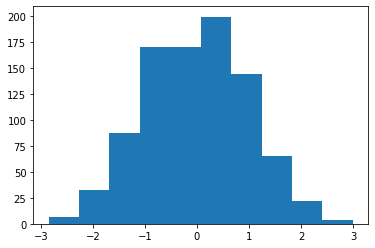

In [38]:
for module in Net.modules():
    if isinstance(module, nn.Conv2d):
        weights = module.weight
        weights = weights.reshape(-1).detach().cpu().numpy()
        print(module.bias) # chech if biases are all 0
        
        plt.hist(weights)
        plt.show()


### modules() vs children()
The difference of the two is very slight but quite important. <br>
As we know, a `nn.Module` object can contain other `nn.Module` objects as it's data members. <br>
`nn.children()` will only return an *iterable* of the `nn.Module` objects which are data members. <br>
___
on the other hand, `nn.Modules` goes *recursively* inside each `nn.Module` object, printing each `nn.Module` object that comes along the way until there are no `nn.module` object left.

In [0]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.convBN = nn.Sequential(nn.Conv2d(10,10,3),nn.BatchNorm2d(10))
        self.linear = nn.Linear(10,2)

    def forward(self,x):
        pass

In [41]:
Net = myNet()
print("printing children\n----------------------------------------------")
print(list(Net.children()))
print("\n\nprinting modules\n---------------------------------------------")
print(list(Net.modules()))

printing children
----------------------------------------------
[Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Linear(in_features=10, out_features=2, bias=True)]


printing modules
---------------------------------------------
[myNet(
  (convBN): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=10, out_features=2, bias=True)
), Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)), BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Linear(in_features=10, out_features=2, bias=True)]


### Summary on printing info about model
PyToch provides 4 convinient functions for printing out infomation our model:
1. `named_parameters`. Return an *iterator* which gives a tuple containing **name** of the parameters (e.g., `self.conv` would have `conv.weight` and `conv.bias`)
2. `named_modules`.  Similar to above but return `modules()` functions
3. `named_children`. Similar to above but return `children()`
4. `named_buffers`.  Return buffer tensors such as running mean average of a Batch Norm layers

In [42]:
for x in Net.named_modules():
  print(x[0], x[1], "\n-------------------------------")

 myNet(
  (convBN): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=10, out_features=2, bias=True)
) 
-------------------------------
convBN Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
-------------------------------
convBN.0 Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)) 
-------------------------------
convBN.1 BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
-------------------------------
linear Linear(in_features=10, out_features=2, bias=True) 
-------------------------------


In [44]:
for x in Net.named_children():
  print(x[0], x[1], "\n-------------------------------")

convBN Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
-------------------------------
linear Linear(in_features=10, out_features=2, bias=True) 
-------------------------------


In [45]:
for x in Net.named_children():
  print(x[0], "\n-------------------------------")

convBN 
-------------------------------
linear 
-------------------------------


In [46]:
for x in Net.named_children():
  print(x[1], "\n-------------------------------")

Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
-------------------------------
Linear(in_features=10, out_features=2, bias=True) 
-------------------------------


## Different Learning Rates for Different Layers

Now we have a solid fundation to move on to learn how to apply differnt **hyper-parametes** to different layers or layer groups.<br>
With this, we will be able to apply different learning rate for each layer.

In [0]:
class myNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10,5)
        self.fc2 = nn.Linear(5,2)

    def forward(self, x):
        return self.fc2(self.fc1(x))

In [0]:
Net = myNet()
optimizer = torch.optim.SGD(Net.parameters(), lr=0.5)

Optionally, we can provide our optimizer with a dictionary of **learnable parameters** and their corresponding **settings**

In [0]:
optimizer = torch.optim.SGD([
                             {"params":Net.fc1.parameters(), "lr": 1e-3, "momentum":0.99},
                             {"params":Net.fc2.parameters(), "lr": 1e-2, "momentum":0.9 }
])

## Scheduling Learning Rates
PyTorch provides support for **learning rate scheduling** with it's `torch.optim.lr_scheduler` module. It has a variety of learning rate schedules.<br>
Fortunately, they are all well commented

In [0]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer,max_lr=1e-3, total_steps=1000, epochs=10,steps_per_epoch=100,pct_start=0.4)